In [1]:
import torch
from torchvision.models import resnet18
from torchsummary import summary
from utils import classify
import numpy as np
from matplotlib import pyplot as plt
import os
from male import get_important_neurons, get_positions, associate_channels
import openai
from json import loads

In [2]:
%load_ext autoreload

In [3]:
filename = 'czapi.jpg'

In [4]:
model = resnet18(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
if not os.path.exists(os.path.join('images', 'clipped', filename)):
    plt.imsave(os.path.join('images', 'clipped', filename), image_center_resized)

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'resnet18_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['layer4']
layer_map = {'conv1' : model.bn1, 
             'layer1' : model.layer1[1].bn2, 
             'layer2' : model.layer2[1].bn2, 
             'layer3' : model.layer3[1].bn2, 
             'layer4' : model.layer4[1].bn2}

In [8]:
per_layer_results, per_layer_activations = get_important_neurons(10, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Dogs


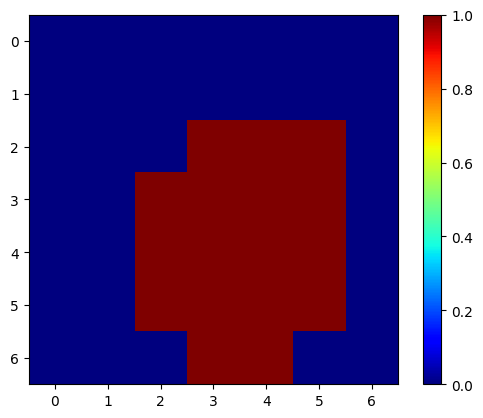

Animals


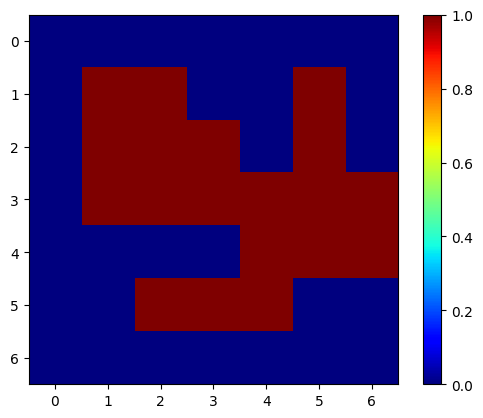

Black and white colored objects


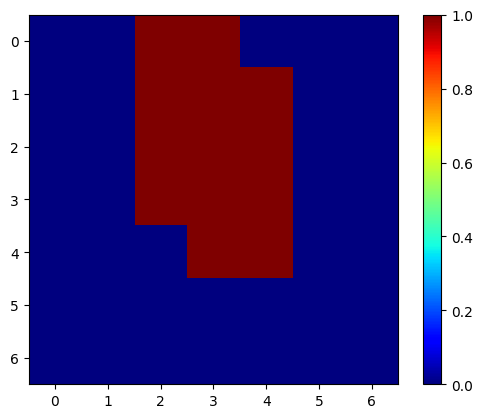

Animals


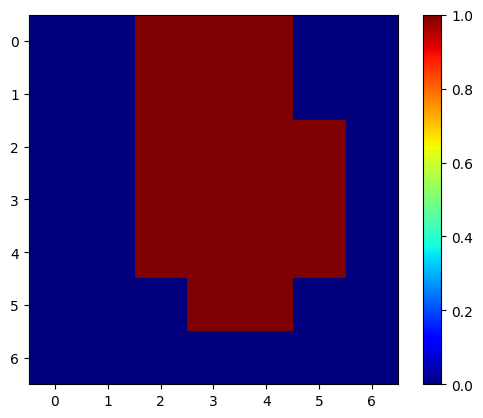

Mouths of animals


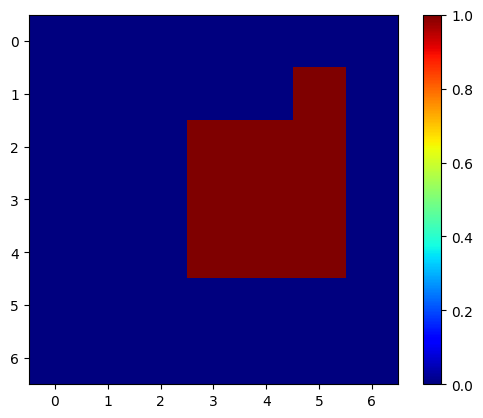

Rounded edges in pictures


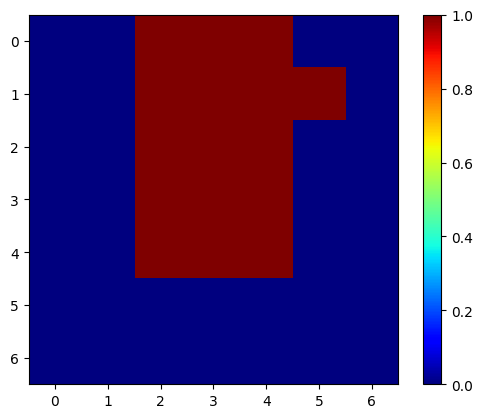

Necks of an object


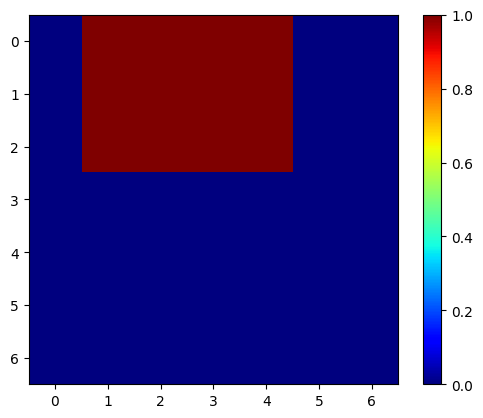

Animals


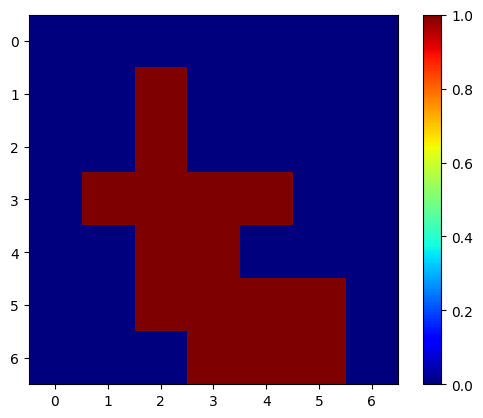

Animals


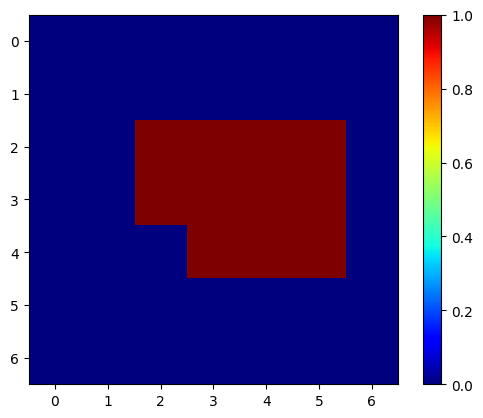

Human instruments


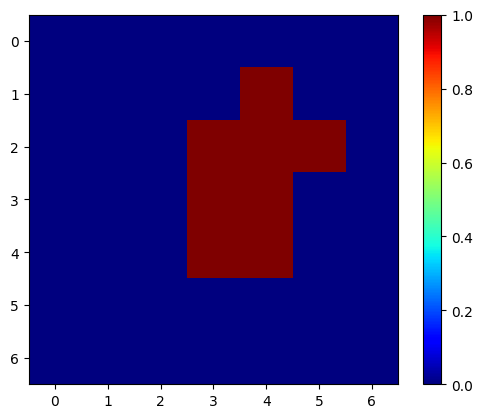

In [9]:
per_layer_positions = get_positions(per_layer_results, per_layer_activations, viz=True)

In [10]:
prompt = str(categories[0]) + ', '
tmp = []
positions = per_layer_positions['layer4']
results = per_layer_results['layer4']
for k, v in positions.items():
    tmp.append({'description' : results[k], 'positions' : [], 'id' : k})
    if len(v) <= 3:
        tmp[-1]['positions'] = v
prompt += str(tmp)
print(prompt)

miniature pinscher, [{'description': 'Dogs', 'positions': ['right', 'bottom', 'center'], 'id': 266}, {'description': 'Animals', 'positions': [], 'id': 280}, {'description': 'Black and white colored objects', 'positions': [], 'id': 46}, {'description': 'Animals', 'positions': [], 'id': 271}, {'description': 'Mouths of animals', 'positions': [], 'id': 402}, {'description': 'Rounded edges in pictures', 'positions': [], 'id': 138}, {'description': 'Necks of an object', 'positions': [], 'id': 302}, {'description': 'Animals', 'positions': [], 'id': 316}, {'description': 'Animals', 'positions': ['right', 'bottom', 'center'], 'id': 282}, {'description': 'Human instruments', 'positions': [], 'id': 475}]


In [11]:
with open('/home/adamwsl/.gpt_api_token/token.txt', 'r') as f:
    token = f.readline().strip()
with open('prompts/system_prompt.txt', 'r') as f:
    system_prompt = f.readline()
with open('prompts/example_prompt_1.txt', 'r') as f:
    example_prompt_1 = f.readline()
with open('prompts/example_output_1.txt', 'r') as f:
    example_output_1 = f.readline()
full_prompt = 'PROMPT: "' + prompt + '"'
print(full_prompt)

PROMPT: "miniature pinscher, [{'description': 'Dogs', 'positions': ['right', 'bottom', 'center'], 'id': 266}, {'description': 'Animals', 'positions': [], 'id': 280}, {'description': 'Black and white colored objects', 'positions': [], 'id': 46}, {'description': 'Animals', 'positions': [], 'id': 271}, {'description': 'Mouths of animals', 'positions': [], 'id': 402}, {'description': 'Rounded edges in pictures', 'positions': [], 'id': 138}, {'description': 'Necks of an object', 'positions': [], 'id': 302}, {'description': 'Animals', 'positions': [], 'id': 316}, {'description': 'Animals', 'positions': ['right', 'bottom', 'center'], 'id': 282}, {'description': 'Human instruments', 'positions': [], 'id': 475}]"


In [12]:
with open('prompts/full_prompt.txt', 'r') as f:
    whole_prompt = f.readlines()
whole_prompt = ''.join(whole_prompt)
full_prompt = whole_prompt + 'PROMPT: "' + prompt + '"'
print(full_prompt)

You are tasked with a problem of creating a deep convolutional network classification EXPLANATION. You will be given an python object in form of `chosen class, [{'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, neuron id' : *neuron id *}, {'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, 'neuron id' : *neuron id *}, …]` where `...` means that there might be numerous triplets more, and  which is a class that model has picked. I want you to do two things:
1. create a grammatically correct sentence which will explain the model's decision.
2. Decide which neuron descriptions do not fit with `chosen class` and do not include those neuron descriptions in the final explanation. What I mean by 'do not fit' is that they are completely unrelated with chosen class (like 'dentist' and 'animal heads'). Do include in final explanation neuron descriptions which aren't directly related to chosen class, but they may be indirectly

In [18]:
API_KEY = token
openai.api_key = API_KEY
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "user", "content": full_prompt},
    ], 
  temperature=0.1
)

In [19]:
from pprint import pprint
pprint(response["choices"][0]["message"]["content"])

("The model's decision was 'miniature pinscher' because in the last layer it "
 "discovered 'Dogs' at the 'right', 'bottom', and 'center' of the image "
 "(neuron 266), 'Animals' (neuron 280), 'Animals' (neuron 271), 'Rounded edges "
 "in pictures' (neuron 138), 'Necks of an object' (neuron 302), 'Animals' "
 "(neuron 316), and 'Animals' at the 'right', 'bottom', and 'center' of the "
 "image (neuron 282). Neurons 'Black and white colored objects' (neuron 46) "
 "and 'Human instruments' (neuron 475) do not fit with the chosen class.")


In [20]:
%autoreload 2
from male import associate_channels
x = associate_channels(input_batch=input_batch, 
                       prev_layer=model.layer3[1].conv2, 
                       prev_out_channels=256,
                       curr_layer=model.layer4[0].conv1, 
                       target_ch_id=266, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[119, 220, 163, 252, 231, 120, 188, 128, 248, 53]


In [24]:
query = descriptions[descriptions['layer'] == 'layer2']
tops = list(torch.argsort(x).numpy())[:10]
print(tops)
query =  query[query['unit'].isin(tops)]
query

[30, 95, 60, 25, 4, 109, 106, 58, 31, 77]


,layer,unit,description
132,layer2,4,Red and orange objects
153,layer2,25,Circles
158,layer2,30,Horizontal lines
159,layer2,31,Black and white colored objects
186,layer2,58,Circles
188,layer2,60,Stripes
205,layer2,77,Stripes
223,layer2,95,Edges of objects
234,layer2,106,Animal eyes
237,layer2,109,Circles


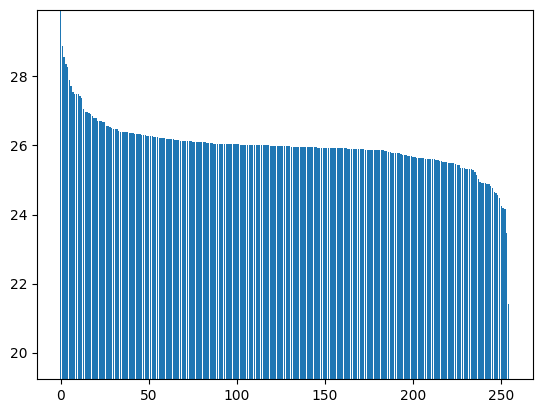

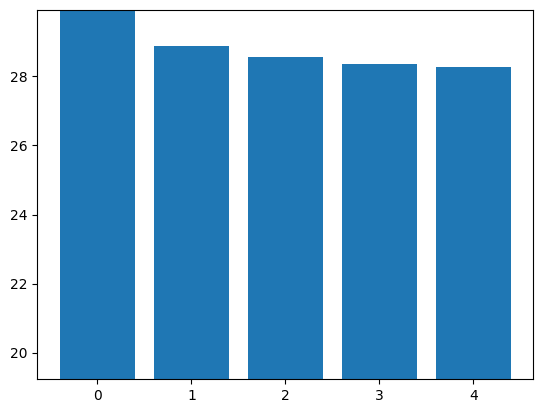

In [17]:
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(y), max(y))
plt.bar(range(len(y[:5])), y[:5])
plt.show()